In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist

In [2]:
df = pd.read_csv("../../dataset/df_cleaned_1atc.tsv", sep="\t")
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"])
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"])
df_n06a = (
    df[df["atc_level3"] == "N06A"]
    .sort_values(by=["eid", "drug_era_start_date"])
    .reset_index(drop=True)
)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A


In [3]:
# create a mapping for each atc_code to a number
atc_code_to_num = {
    atc_code: i + 1 for i, atc_code in enumerate(df_n06a["atc_code"].unique())
}
df_n06a["atc_code_num"] = df_n06a["atc_code"].map(atc_code_to_num)
df_n06a.head()

,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3,atc_code_num
0,1000014,128849065239,710062,2010-02-15,2010-02-26,2,0,amitriptyline,N06AA09,12,N06A,1
1,1000014,1245540543307,710062,2010-04-23,2010-04-30,1,0,amitriptyline,N06AA09,8,N06A,1
2,1000014,670014960364,710062,2010-06-25,2010-07-02,1,0,amitriptyline,N06AA09,8,N06A,1
3,1000014,1228360666726,710062,2014-03-10,2014-03-17,1,0,amitriptyline,N06AA09,8,N06A,1
4,1000041,661424994579,797617,2014-02-14,2014-02-27,1,0,citalopram,N06AB04,14,N06A,2


In [4]:
alphabet_size = len(atc_code_to_num) + 1
print(f"alphabet size: {alphabet_size}")

alphabet size: 10


In [55]:
# create sequences for each eid
def eid_to_sequence(eid_df: pd.DataFrame):
    # Sort by start date
    eid_df = eid_df.sort_values("drug_era_start_date").reset_index(drop=True)

    # Initialize sequence
    sequence = []

    for index, row in eid_df.iterrows():
        sequence.append(row["atc_code_num"])
        if index != len(eid_df) - 1:
            sequence.append(0)

    return sequence


eids = np.random.choice(df_n06a["eid"].unique(), 1000)
sequences = [eid_to_sequence(df_n06a[df_n06a["eid"] == eid]) for eid in eids]
sequence_lengths = [len(sequence) for sequence in sequences]

print(f"average sequence length: {np.mean(sequence_lengths)}")
print(f"std sequence length: {np.std(sequence_lengths)}")
print(f"max sequence length: {np.max(sequence_lengths)}")
print(f"min sequence length: {np.min(sequence_lengths)}")

average sequence length: 11.36
std sequence length: 20.55836569379969
max sequence length: 169
min sequence length: 1


In [56]:
# Example Usage
sequence1 = sequences[10]
sequence2 = sequences[12]

In [57]:
df_n06a[df_n06a["eid"] == eids[10]]


,eid,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,atc_level3,atc_code_num
230522,3731619,1090921739056,710062,2009-02-17,2009-02-20,1,0,amitriptyline,N06AA09,4,N06A,1


In [58]:
def sequence_edit_distance(seq1: list, seq2: list) -> int:
    """
    Calculate the minimum edit distance between two numerical sequences.
    Operations allowed: insertion, deletion, substitution

    Args:
        seq1: First sequence of numbers
        seq2: Second sequence of numbers

    Returns:
        int: Minimum number of operations required to transform seq1 into seq2
    """
    # Create matrix of size (m+1)x(n+1)
    m, n = len(seq1), len(seq2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize first row and column
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],  # deletion
                    dp[i][j - 1],  # insertion
                    dp[i - 1][j - 1],  # substitution
                )

    return dp[m][n]


# Example usage:
distance = sequence_edit_distance(sequence1, sequence2)
print(f"Edit distance between {sequence1} and {sequence2}: {distance}")

Edit distance between [1] and [2, 0, 3, 0, 3, 0, 2]: 7


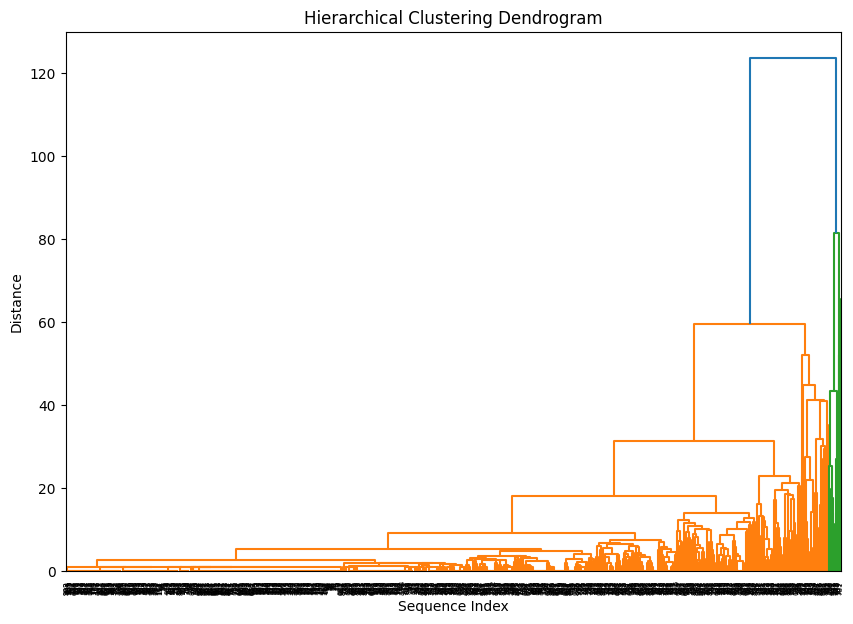

Number of clusters: 5

Cluster 1 has 949 sequences:
Sequence indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  80  81  82  83  84  85  86  87  88  89  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 122 123 124 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 215 216 217 218 220 221 222 223 224
 225 226 227 228 229 230 231 233 234 235 237 238 239 2

In [59]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt


def create_distance_matrix(sequences: list) -> np.ndarray:
    """
    Create a distance matrix using edit distance between all pairs of sequences
    """
    n = len(sequences)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            dist = sequence_edit_distance(sequences[i], sequences[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix


def cluster_sequences(sequences: list, n_clusters: int = 5):
    """
    Cluster sequences using hierarchical clustering

    Args:
        sequences: List of sequences to cluster
        n_clusters: Number of clusters (if None, distance_threshold must be provided)
        distance_threshold: Distance threshold for clustering (if None, n_clusters must be provided)
    """
    # Create distance matrix
    dist_matrix = create_distance_matrix(sequences)

    # Convert to condensed form required by linkage
    condensed_dist = squareform(dist_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(
        condensed_dist, method="average"
    )  # you can try 'single', 'complete', 'ward' etc.

    # Create clusters
    clusters = fcluster(linkage_matrix, n_clusters, criterion="maxclust")

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sequence Index")
    plt.ylabel("Distance")
    plt.show()

    return clusters


# Option 1: Cluster by number of clusters
clusters = cluster_sequences(sequences, n_clusters=5)

# Analyze results
print(f"Number of clusters: {len(np.unique(clusters))}")
for cluster_id in np.unique(clusters):
    cluster_members = np.where(clusters == cluster_id)[0]
    print(f"\nCluster {cluster_id} has {len(cluster_members)} sequences:")
    print(f"Sequence indices: {cluster_members}")

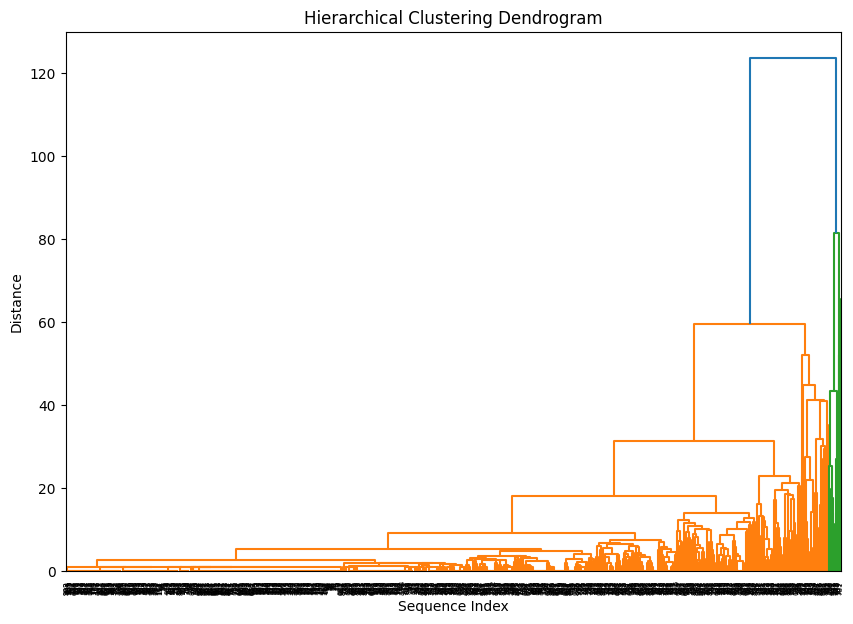


Cluster 1:
Number of sequences: 949
Average sequence length: 7.48
Length range: 1 - 53
Average pairwise distance: 10.28

Cluster 2:
Number of sequences: 36
Average sequence length: 64.11
Length range: 45 - 91
Average pairwise distance: 36.69

Cluster 3:
Number of sequences: 12
Average sequence length: 130.00
Length range: 101 - 169
Average pairwise distance: 30.80

Cluster 4:
Number of sequences: 2
Average sequence length: 133.00
Length range: 107 - 159
Average pairwise distance: 52.00

Cluster 5:
Number of sequences: 1
Average sequence length: 125.00
Length range: 125 - 125


In [60]:
def analyze_clusters(sequences: list, clusters: np.ndarray):
    """
    Analyze the characteristics of each cluster
    """
    unique_clusters = np.unique(clusters)

    for cluster_id in unique_clusters:
        # Get sequences in this cluster
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_sequences = [sequences[i] for i in cluster_indices]

        # Calculate some statistics
        lengths = [len(seq) for seq in cluster_sequences]

        print(f"\nCluster {cluster_id}:")
        print(f"Number of sequences: {len(cluster_sequences)}")
        print(f"Average sequence length: {np.mean(lengths):.2f}")
        print(f"Length range: {min(lengths)} - {max(lengths)}")

        # Calculate average pairwise distance within cluster
        if len(cluster_sequences) > 1:
            distances = []
            for i in range(len(cluster_sequences)):
                for j in range(i + 1, len(cluster_sequences)):
                    dist = sequence_edit_distance(
                        cluster_sequences[i], cluster_sequences[j]
                    )
                    distances.append(dist)
            print(f"Average pairwise distance: {np.mean(distances):.2f}")


# Use it after clustering
clusters = cluster_sequences(sequences, n_clusters=5)
analyze_clusters(sequences, clusters)

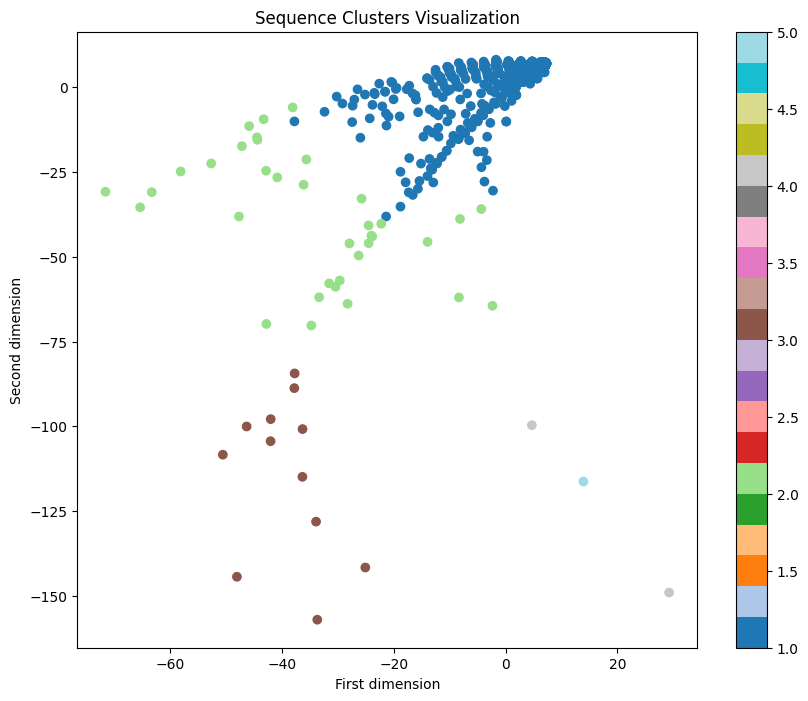

In [61]:
from sklearn.manifold import MDS
import seaborn as sns


def visualize_clusters(sequences: list, clusters: np.ndarray):
    """
    Visualize clusters using MDS for dimensionality reduction
    """
    # Create distance matrix
    dist_matrix = create_distance_matrix(sequences)

    # Use MDS to reduce to 2D
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords_2d = mds.fit_transform(dist_matrix)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=clusters, cmap="tab20")
    plt.colorbar(scatter)
    plt.title("Sequence Clusters Visualization")
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.show()


# Visualize the clusters
visualize_clusters(sequences, clusters)